In [1]:
import findspark
findspark.init()

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col, year, quarter, lit, to_date, to_timestamp, concat, avg
from pyspark.sql.types import DateType, TimestampType
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.ml.feature import Imputer
from pyspark.sql import DataFrameStatFunctions as statFunc
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import IndexToString
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import PCA


from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.metrics import roc_curve, auc


#%matplotlib inline

import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib
# Force matplotlib to not use any Xwindows backend.
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats

import plotly.plotly as py

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

import os
memory = '4g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

#sc = SparkContext()  
SparkContext.setSystemProperty('spark.executor.memory', '4g')
SparkContext.setSystemProperty('spark.driver.memory', '4g')

spark_conf = SparkConf().setAll(pairs = [('spark.executor.memory', '4g'), ('spark.executor.cores', '3'), ('spark.cores.max', '3'), ('spark.driver.memory','4g')])

spark = SparkSession.builder.master("local[*]").config(conf = spark_conf).appName("Lending-Club Loan Analysis using Pyspark").getOrCreate()
sqlContext = SQLContext(spark)

spark.sparkContext.setLogLevel('ERROR')

import warnings
warnings.filterwarnings('ignore')


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start

### Load Data to Spark DataFrame

In [2]:
loanDF = spark.read.csv("loan.csv", header=True, mode="DROPMALFORMED")
#loanDF = spark.read.csv("loan.csv", header=True, mode="DROPMALFORMED", inferSchema =True)

#loanDFRows = loanDF.count()

loanDF.printSchema()

# Loading it as pandasDF also, only for the comparison/testing.
loanDF_Pandas = pd.read_csv("loan.csv", low_memory=False)

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: string (nullable = true)
 |-- funded_amnt: string (nullable = true)
 |-- funded_amnt_inv: string (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

### Find the Feature columns which has more than 50% empty data

In [3]:
# find list of columns which has more than 50% of data missing.
def findMissingValueCols(df):
    #df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
    missingValueColumns = []
    for column in df.columns:
        nullRows = df.where(col(column).isNull()).count()
        print(column, "--", nullRows)
        if nullRows > loanDFRows*0.5 : # i.e. if ALL values are NULL
            missingValueColumns.append(column)
    return missingValueColumns

# columns names which has more than 50% data missing
#missingValueColList = findMissingValueCols(loanDF)

#print(missingValueColList)

#### Analyzing Loan amount and Interest rates

- Frequency distribution of loan amount with gamma distribution. 
- Five number summary distribution of loan amount.
- Frequency distribution of interest rates with gamma distribution. 
- Five number summary distribution of interest rates.

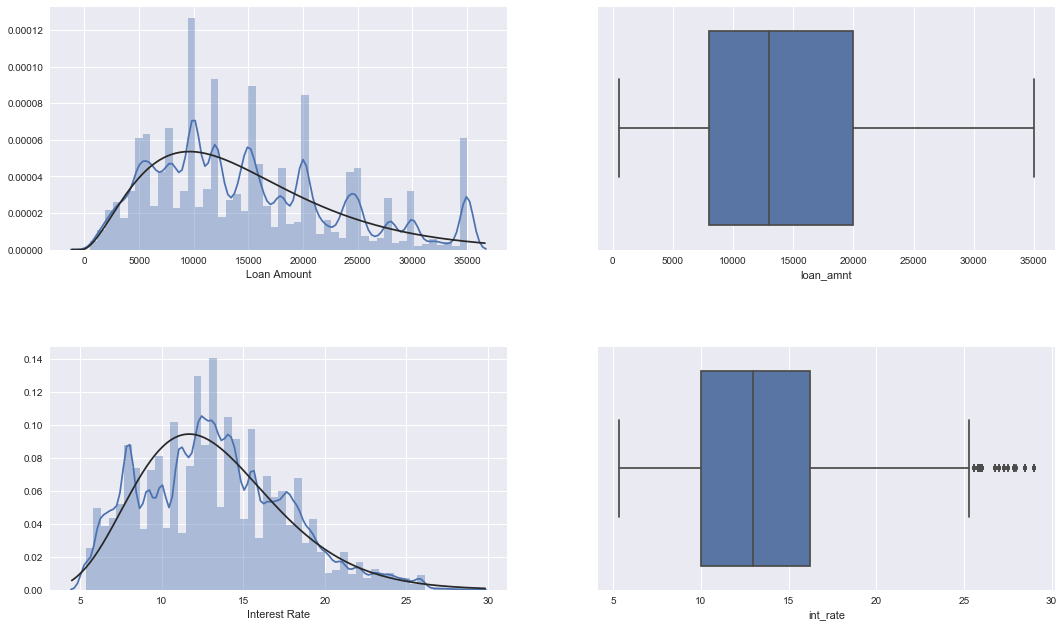

In [4]:
loanDF = loanDF.withColumn("loan_amnt",loanDF["loan_amnt"].cast('float'))
loanDF = loanDF.withColumn("int_rate",loanDF["int_rate"].cast('float'))

tmp = loanDF.select("loan_amnt", "int_rate").toPandas()
#loanDF.printSchema()

fig, ax =plt.subplots(2,2, figsize=(18,12))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

# Loan amount distribution plots
sns.distplot(tmp.loan_amnt, fit=stats.gamma, axlabel="Loan Amount", label="Loan Amount Frequency distribution", ax=ax[0][0])
sns.boxplot(x=tmp.loan_amnt, ax=ax[0][1])

# Interest rates distribution plots
sns.distplot(tmp.int_rate, fit=stats.gamma, axlabel="Interest Rate", label="Interest Frequency distribution", ax=ax[1][0])
sns.boxplot(x=tmp.int_rate, ax=ax[1][1])

fig.show()

fig.savefig("LoanDistribution.pdf")

### Converting the issue_d as DateType. 
#### In order to group by quarterly, adding a new column as "issue_year" which parse the date field and get year and quarter details. 

In [5]:
# Converting issue_d to datetype for the aggregation, Creating a new field for monthly quarters. 
#loanDF.printSchema
#loanDF.select("issue_d").show(10)

loanDF = loanDF.withColumn("issue_d_dateType", to_date("issue_d", "MM/dd/yyyy"))

loanDF = loanDF.withColumn("issue_year", concat(year("issue_d_dateType"), lit("Q"), quarter("issue_d_dateType")))

#loanDF.select("issue_d", "issue_d_dateType", "issue_year").show(10)

#loanDF.printSchema

#loanDF.select("issue_year").distinct().show()

#### Analyzing Loans Interest rates over time

- Number of loan's growth over time
- Total loan book value growth over time
- Customers loan requirements over time (Median loan amount)
- Median interest rates over time

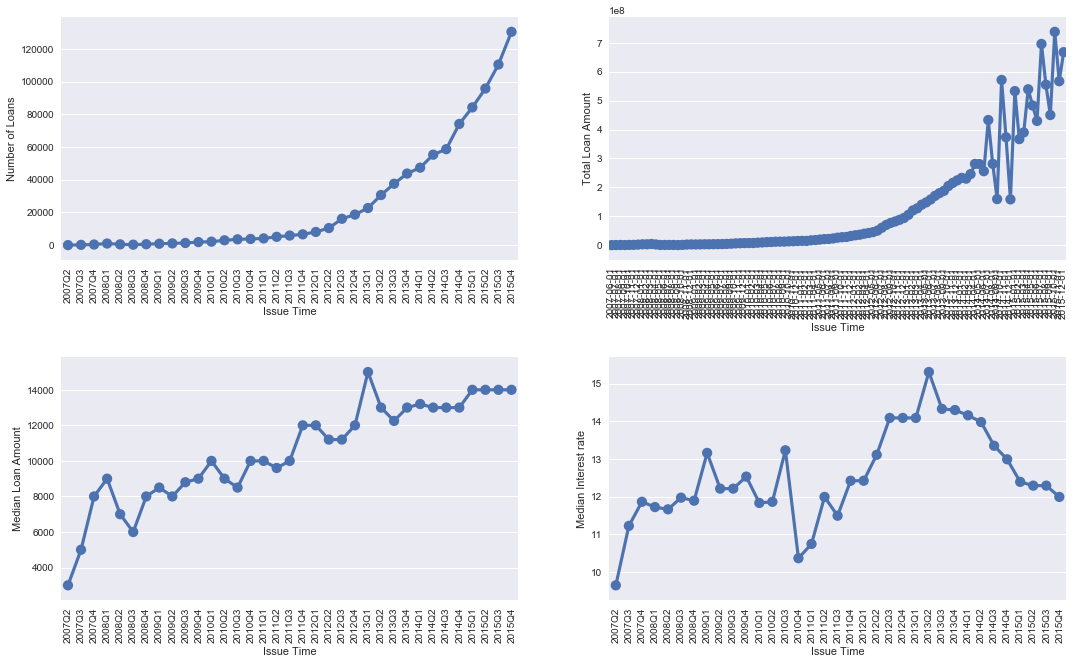

In [6]:
loanDF.registerTempTable("loanDFTable")

fig, ax =plt.subplots(2,2, figsize=(18,12))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

# Number of loan over year
loansOverTime = loanDF.sort("issue_year").groupBy("issue_year").count().toPandas()
#print(loansOverTime)
loansOverTime.columns = ["Issue Time", "Number of Loans"]
s0=sns.pointplot(x=loansOverTime["Issue Time"], y=loansOverTime["Number of Loans"], ax=ax[0][0])
s0.set_xticklabels(s0.get_xticklabels(),rotation=90)

# loan Amount over year
totalloansOverTime = loanDF.sort("issue_d_dateType").groupBy("issue_d_dateType").sum('loan_amnt').toPandas()
#print(totalloansOverTime)
totalloansOverTime.columns = ["Issue Time", "Total Loan Amount"]
s1 = sns.pointplot(x=totalloansOverTime['Issue Time'], y=totalloansOverTime["Total Loan Amount"], capsize=.2, ax=ax[0][1])
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)


# Median Loan Amount, grouped by issue year
medianloanAmtOverTime = sqlContext.sql("select issue_year, percentile_approx(loan_amnt, 0.5) as loan_amnt_med_val from loanDFTable group by issue_year order by issue_year").toPandas()
#print(medianloanAmtOverTime)
medianloanAmtOverTime.columns = ["Issue Time", "Median Loan Amount"]
s2 = sns.pointplot(x=medianloanAmtOverTime['Issue Time'], y=medianloanAmtOverTime["Median Loan Amount"], capsize=.2, ax=ax[1][0])
s2.set_xticklabels(s2.get_xticklabels(),rotation=90)

# Median Interest rate, grouped by issue year 
medianIntrateOverTime = sqlContext.sql("select issue_year, percentile_approx(int_rate, 0.5) as int_rate_med_val from loanDFTable group by issue_year order by issue_year").toPandas()
#print(medianIntrateOverTime)
medianIntrateOverTime.columns = ["Issue Time", "Median Interest rate"]
s3 = sns.pointplot(x=medianIntrateOverTime['Issue Time'], y=medianIntrateOverTime["Median Interest rate"], capsize=.2, ax=ax[1][1])
s3.set_xticklabels(s3.get_xticklabels(),rotation=90)

fig.show()

fig.savefig("LoanPatternOverTime.pdf")

### Loan Counts group by loan_status

In [7]:
#loanDF.registerTempTable("loanDFTable")

loanDF.groupBy('loan_status').count().sort("count", ascending=False).show()
#print(loanDF.loan_status.value_counts())

#print((loanDF[loanDF.loan_status.isin(["Default"])]).verification_status.value_counts())

#loanDF.loan_status.describe()

+--------------------+------+
|         loan_status| count|
+--------------------+------+
|             Current|601776|
|          Fully Paid|207533|
|         Charged Off| 45215|
|  Late (31-120 days)| 11591|
|              Issued|  8460|
|     In Grace Period|  6253|
|   Late (16-30 days)|  2357|
|Does not meet the...|  1969|
|             Default|  1219|
|Does not meet the...|   751|
+--------------------+------+



### Default Loan Count group by varification_status

In [8]:
#DataFrame newdf = df.select(df.col("*")).filter("somecol <= 10")

loanDF.filter("loan_status == 'Default'").groupBy('verification_status').count().show()

+-------------------+-----+
|verification_status|count|
+-------------------+-----+
|           Verified|  479|
|    Source Verified|  462|
|       Not Verified|  278|
+-------------------+-----+



### Alalyzing Loans over loan status.

- Number of loans over for each loan status
- Distribution of total accounts for each status
- Distribution of loan amount with the probability density for each loan value over loan status

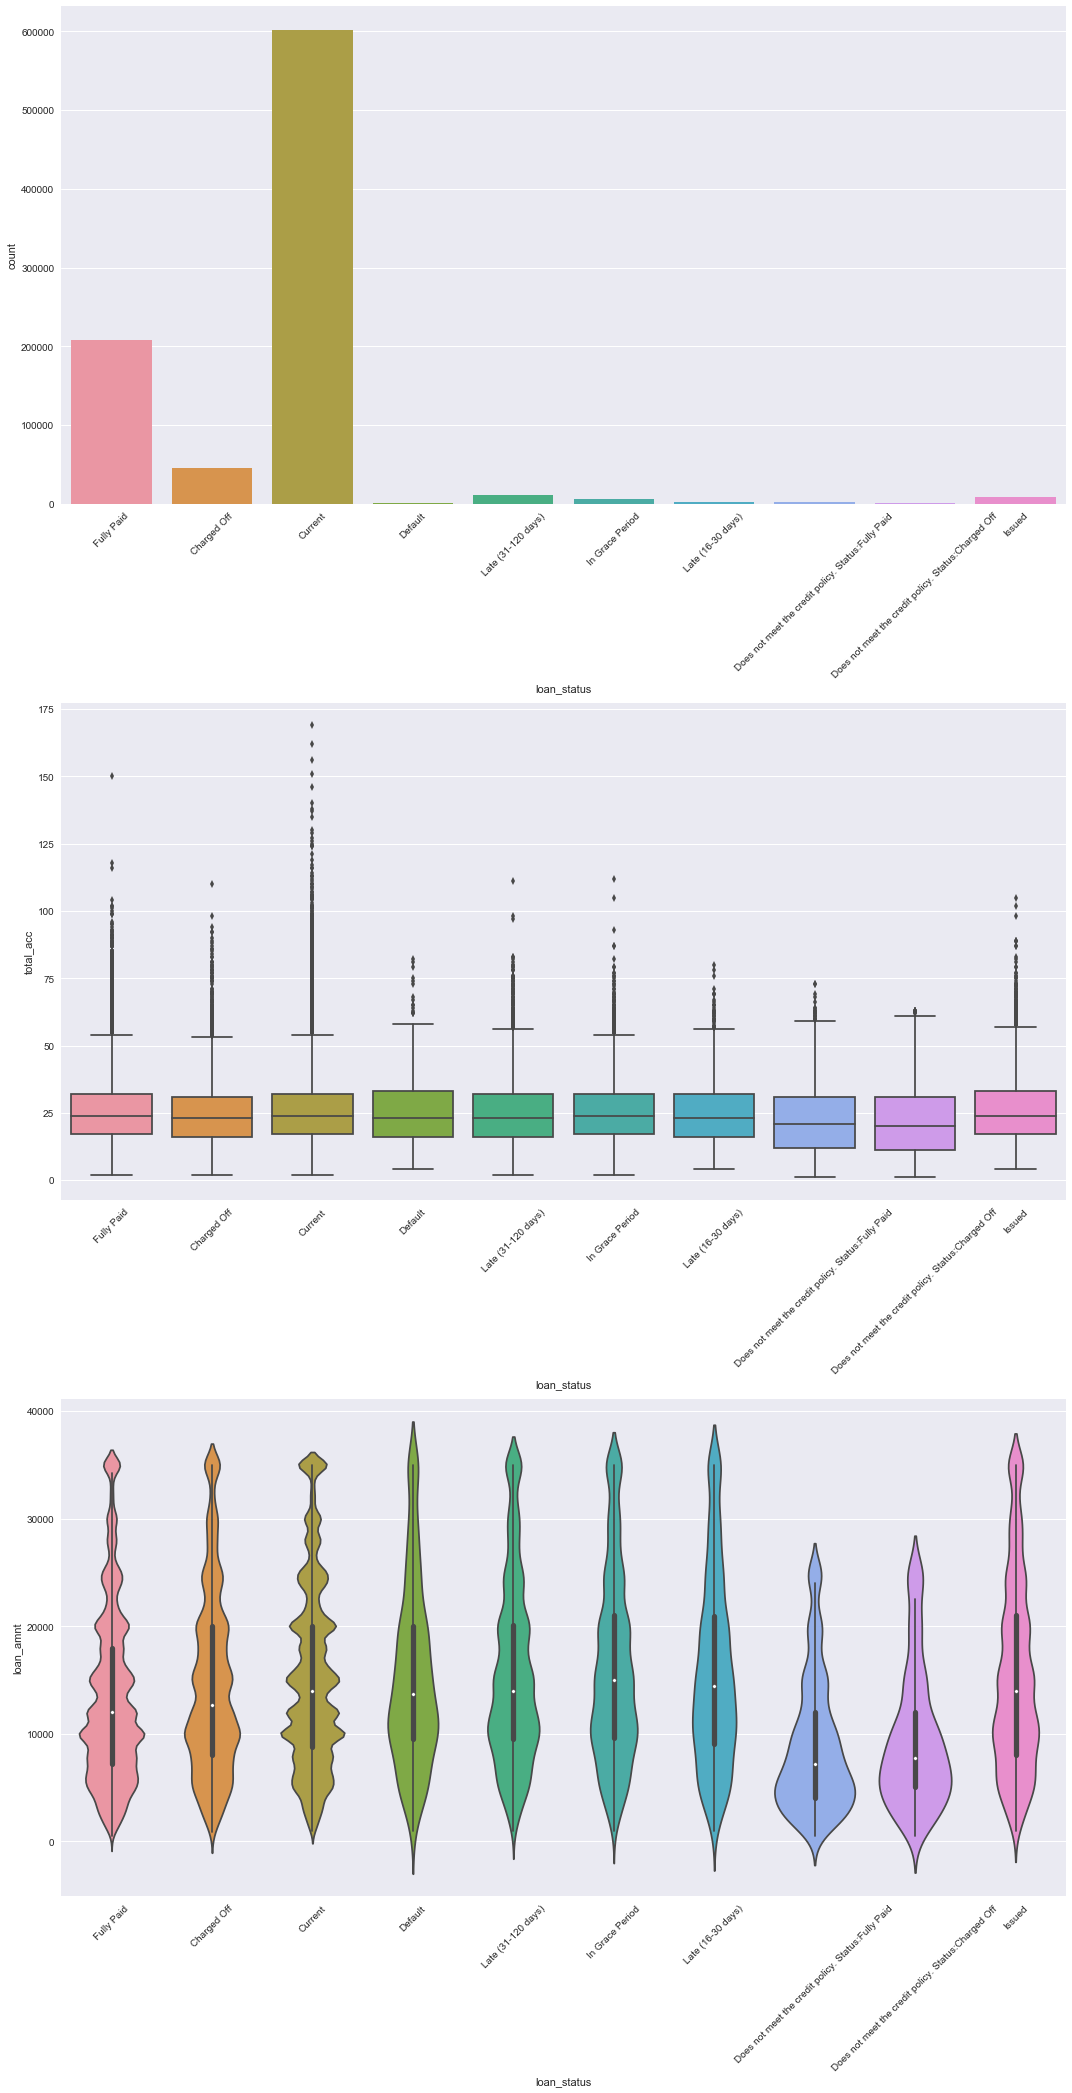

In [9]:
loanDF = loanDF.withColumn("total_acc",loanDF["total_acc"].cast('float'))

tmp = loanDF.select("loan_status", "total_acc", "loan_amnt").toPandas()

fig, ax =plt.subplots(3,1,figsize=(18,30))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="loan_status", data=tmp,ax=ax[0])
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

s1 = sns.boxplot(x="loan_status", y="total_acc", data=tmp,ax=ax[1])
s1.set_xticklabels(s1.get_xticklabels(),rotation=45)

# loan Amount over loan status 
#totalloansOverStatus = pd.DataFrame(loanDF.groupby(loanDF.loan_status)['loan_amnt'].sum())
#totalloansOverStatus = loanDF.groupBy('loan_status').sum('loan_amnt').toPandas()
#totalloansOverStatus.columns = ["Total Loan Amount"]
#totalloansOverStatus.index.names = ["Loan Status"]

s2 = sns.violinplot(x="loan_status", y="loan_amnt", data=tmp,ax=ax[2] , estimator=sum)
#s2 = sns.violinplot(x=totalloansOverStatus.index, y=totalloansOverStatus["Total Loan Amount"],ax=ax[2] )
s2.set_xticklabels(s2.get_xticklabels(),rotation=45)

plt.show()

fig.savefig("LoanOveroanStatus.pdf")

#### Analysing loan amount distribution for each grade, factored over sub grade.

This shows a linear relationship between loan amount and customer credit ratings, Notice here that requested loan amount is slightly higher for the low rating customers.

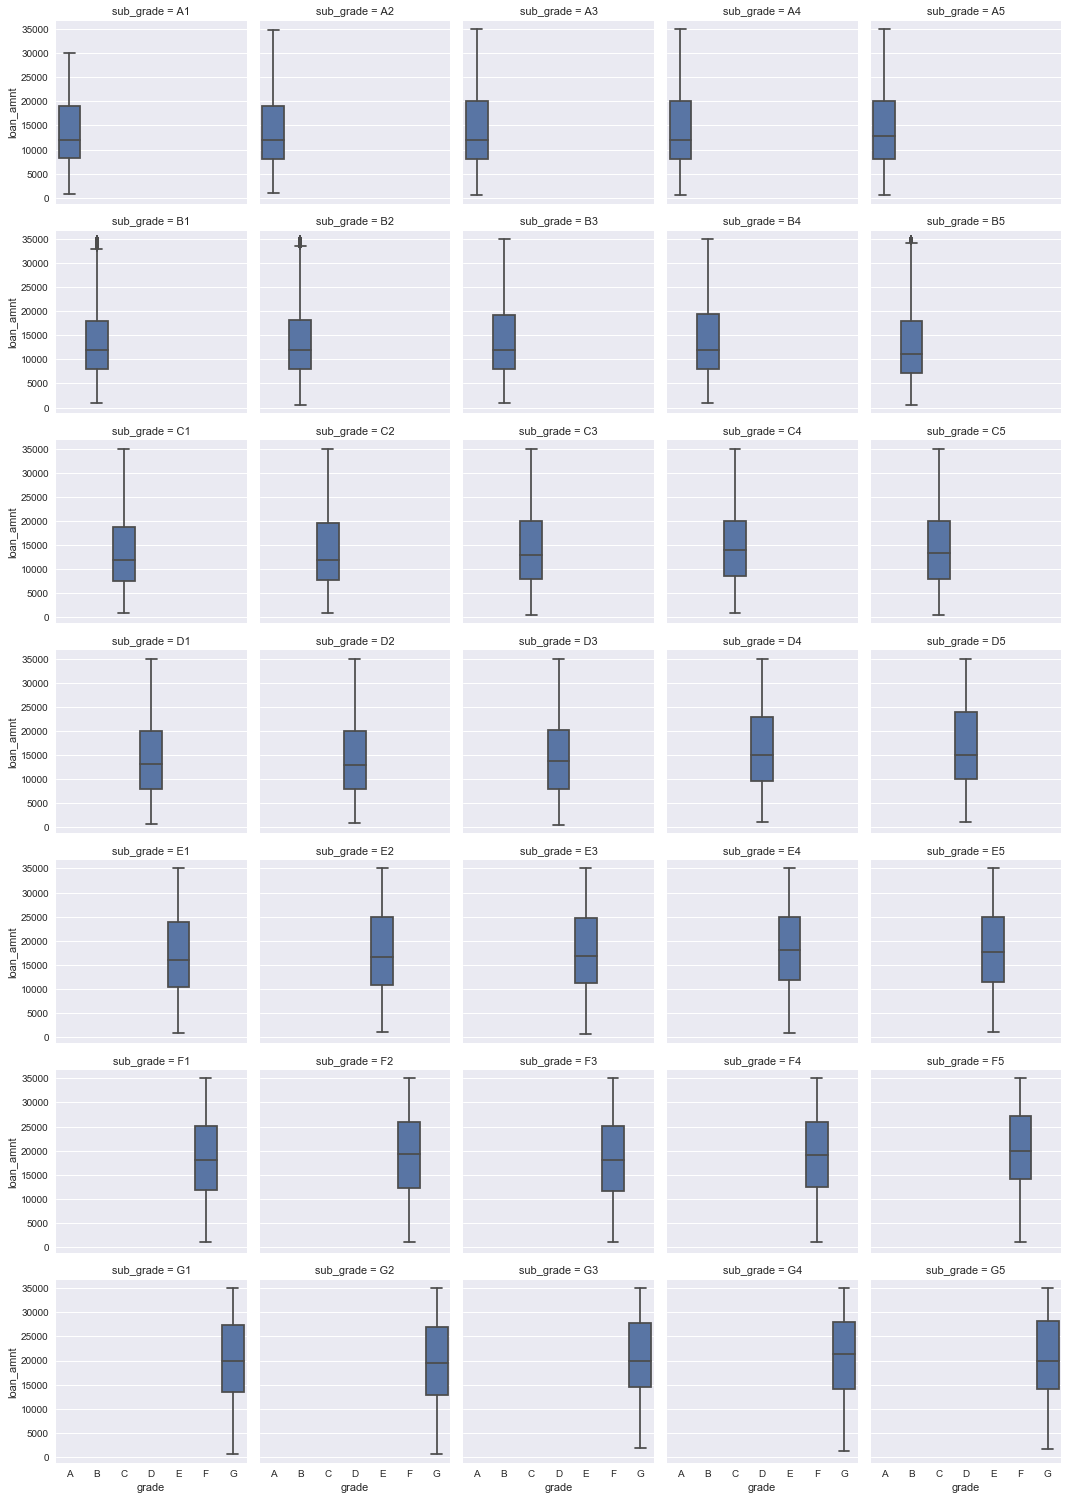

In [10]:
#sns.boxplot(x="grade", y="loan_amnt", data=loanDF)
tmpDF = loanDF.select("sub_grade", "grade", "loan_amnt", "int_rate").toPandas()
tmpDF['grade'] = tmpDF['grade'].astype('category')
tmpDF['sub_grade'] = tmpDF['sub_grade'].astype('category')
#tmpDF['loan_amnt'] = tmpDF['loan_amnt'].astype('float')
#tmpDF['int_rate'] = tmpDF['int_rate'].astype('float')
#loanDF_Pandas['grade'] = loanDF_Pandas['grade'].astype('category')
#loanDF_Pandas['sub_grade'] = loanDF_Pandas['sub_grade'].astype('category')

#print(tmpDF)

g = sns.FacetGrid(tmpDF, col="sub_grade", sharex=True, col_wrap=5)
#g = sns.FacetGrid(loanDF.toPandas(), col="sub_grade", sharex=False, col_wrap=5)
g.map(sns.boxplot, 'grade', 'loan_amnt')

g.savefig("FacetGrid_LoanAmt.pdf")
#fig.savefig("FacetGrid_LoanAmt.pdf")

#### Analyzing interest rate distribution for each grade, factored over sub grade.

This shows the interest rates goes high for low credit rating customers. 

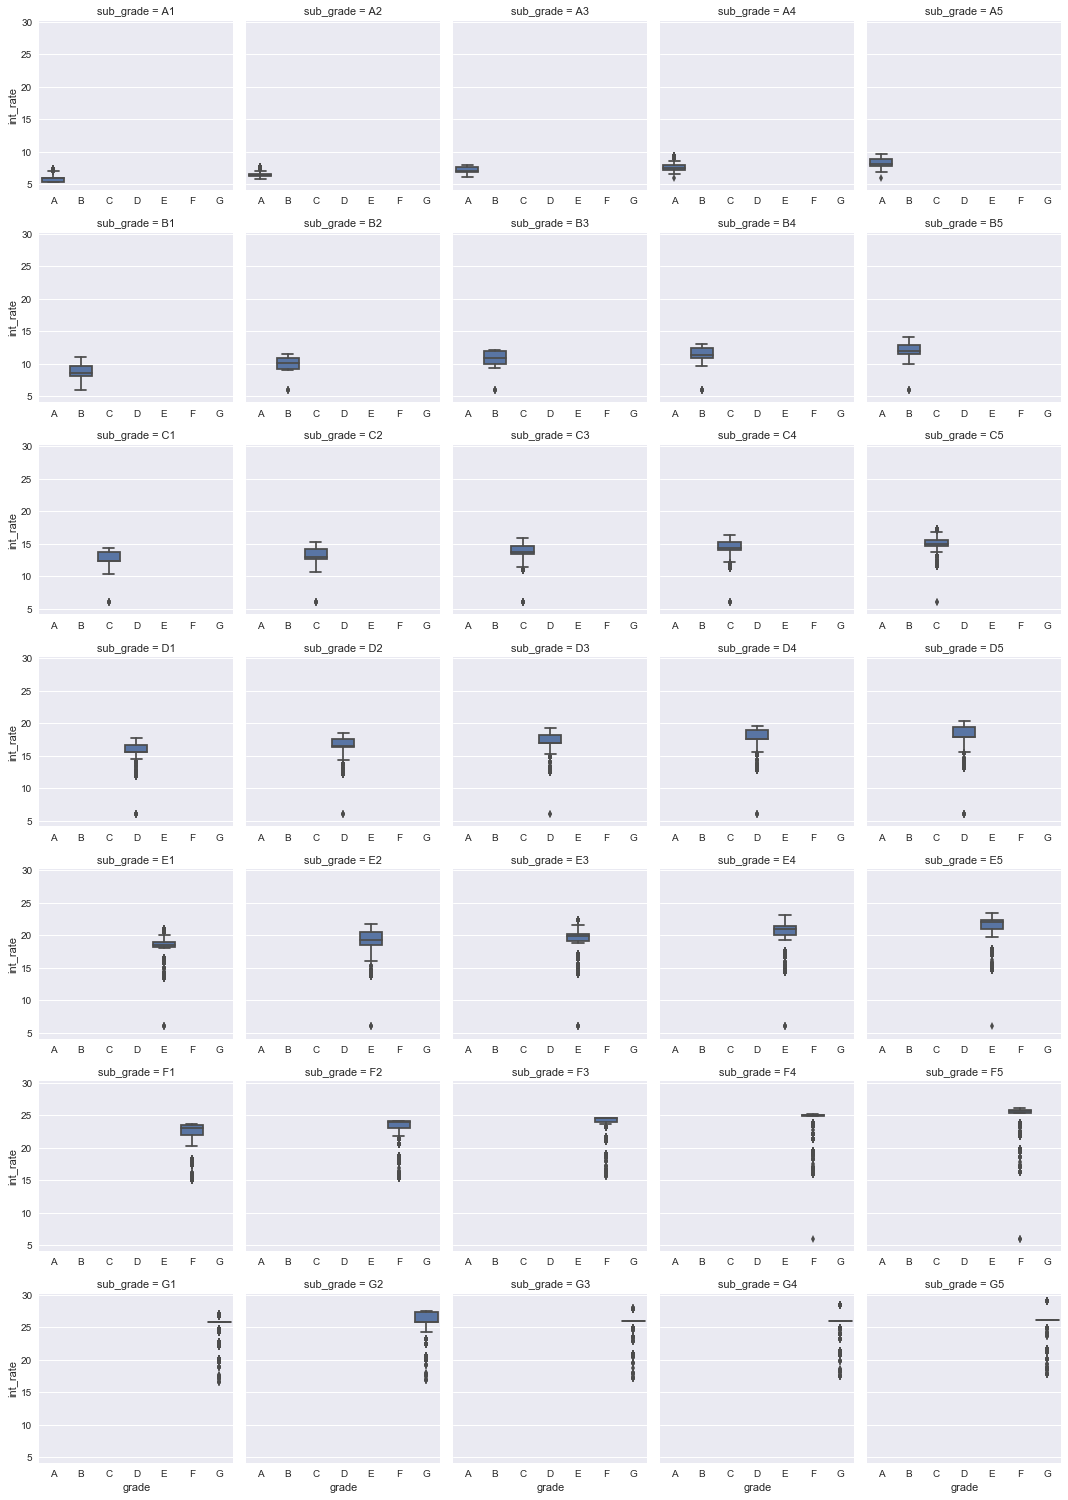

In [11]:
g = sns.FacetGrid(tmpDF, col="sub_grade", sharex=False, col_wrap=5)
#g = sns.FacetGrid(loanDF.toPandas(), col="sub_grade", sharex=False, col_wrap=5)
g.map(sns.boxplot, 'grade', 'int_rate')

g.savefig("FacetGrid_LoanInt.pdf")
#figure.savefig("FacetGrid_LoanInt.pdf")

### US states map with the total loan amount 

In [13]:
totalloansByState = loanDF.groupBy("addr_state").sum('loan_amnt').toPandas()
totalloansByState.columns = ["US-State", "Total Loan Amount"]

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'], [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = dict(
        type='choropleth',
        colorscale = scl,
        #autocolorscale = False,
        locations = totalloansByState['US-State'],
        z = totalloansByState['Total Loan Amount'].astype(float),
        locationmode = 'USA-states',
        text = totalloansByState['US-State'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Billions USD"
        ),
        #colorscale = 'Viridis', 
        reversescale = True
    )

layout = dict(
        title = 'Total Loan Amount by US States',
        geo = dict(
            #scope='usa',
            projection=dict( type='albers usa' ),
            #showlakes = True,
            showframe=False
            #lakecolor = 'rgb(255, 255, 255)',
        ),
    )

#fig = dict(data=data, layout=layout)
#url = py.plot(fig, filename='d3-cloropleth-map')
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap, validate=False, image = 'png', filename='StateMapLoanAmount')

### US states map with the median interest rates

Interest rates looks slightly higher since i am using state wise median interest rate (Avg doesnt make sence in this case). Uncomment the code in case of maximum/minimum interest rates. 

In [14]:
loanDF.registerTempTable("loanDFTable")

# Median Interest rate - Statewise
medianIntRateByState = sqlContext.sql("select addr_state, percentile_approx(int_rate, 0.5) as int_rate_med_val from loanDFTable group by addr_state").toPandas()
#print(medianIntRateByState)
medianIntRateByState.columns = ["US-State", "Median Interest Rate"]

# Max Interest rate - Statewise
#maxIntRateByState = sqlContext.sql("select addr_state, max(int_rate) as int_rate_max_val from loanDFTable group by addr_state").toPandas()
#print(maxIntRateByState)
#maxIntRateByState.columns = ["US-State", "Max Interest Rate"]

# Min Interest rate - Statewise
#minIntRateByState = sqlContext.sql("select addr_state, min(int_rate) as int_rate_min_val from loanDFTable group by addr_state").toPandas()
#print(minIntRateByState)
#minIntRateByState.columns = ["US-State", "Min Interest Rate"]

#print(totalloansByState)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'], [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = dict(
        type='choropleth',
        colorscale = scl,
        #autocolorscale = False,
        locations = medianIntRateByState['US-State'],
        z = medianIntRateByState['Median Interest Rate'].astype(float),
        locationmode = 'USA-states',
        text = medianIntRateByState['US-State'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Interest %"
        ),
        #colorscale = 'Viridis', 
        reversescale = True
    )

layout = dict(
        title = 'Median Interest Rates by US States',
        geo = dict(
            #scope='usa',
            projection=dict( type='albers usa' ),
            #showlakes = True,
            showframe=False
            #lakecolor = 'rgb(255, 255, 255)',
        ),
    )

#fig = dict(data=data, layout=layout)
#url = py.plot(fig, filename='d3-cloropleth-map')
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False, image = 'png', filename='StateMapLoanInterest')

### Creating customer income range (Binning).
Creating 15 income range bins, used gaussian distribution technique to define the income range. <br> <br>

- Total number of loans grouped by income range and loan status
- Total loan amount by income range and loan status

In [16]:
loanDF = loanDF.withColumn("annual_inc",loanDF["annual_inc"].cast('float'))

loanDF = loanDF.withColumn("annual_inc_range", when((col("annual_inc") >= -10000) & (col("annual_inc") < 20000), "0-20000")
                           .when((col("annual_inc") >= 20000) & (col("annual_inc") < 40000), "20000-40000")
                          .when((col("annual_inc") >= 40000) & (col("annual_inc") < 60000), "40000-60000")
                          .when((col("annual_inc") >= 60000) & (col("annual_inc") < 80000), "60000-80000")
                          .when((col("annual_inc") >= 80000) & (col("annual_inc") < 100000), "80000-100000")
                          .when((col("annual_inc") >= 100000) & (col("annual_inc") < 120000), "100000-120000")
                          .when((col("annual_inc") >= 120000) & (col("annual_inc") < 140000), "120000-140000")
                          .when((col("annual_inc") >= 140000) & (col("annual_inc") < 160000), "140000-160000")
                          .when((col("annual_inc") >= 160000) & (col("annual_inc") < 180000), "160000-180000")
                          .when((col("annual_inc") >= 180000) & (col("annual_inc") < 200000), "180000-200000")
                          .when((col("annual_inc") >= 200000) & (col("annual_inc") < 250000), "200000-250000")
                          .when((col("annual_inc") >= 250000) & (col("annual_inc") < 500000), "250000-500000")
                          .when((col("annual_inc") >= 500000) & (col("annual_inc") < 1000000), "500000-1000000")
                          .when((col("annual_inc") >= 1000000) & (col("annual_inc") < 5000000), "1000000-5000000")
                          .otherwise(">5000000"))

#loanDF.groupby("annual_inc_range", "loan_status").count().sort("annual_inc_range", "loan_status").show()

#loanDF.groupBy('loan_status').count().sort("count", ascending=False).show()
                          

In [68]:
#loanDF.select("annual_inc", "annual_inc_range").show(50)

### Total loan amount by income range and loan status

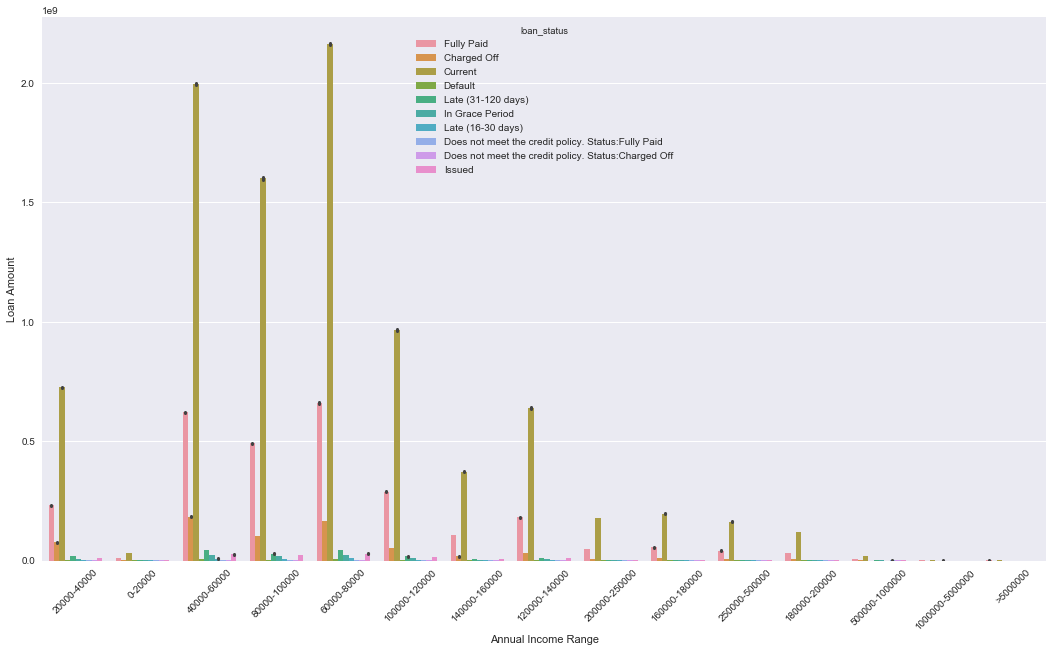

In [17]:
fig, ax =plt.subplots(1,1,figsize=(18,10))

#s0 = sns.barplot(x="annual_inc_range", y="loan_amnt", hue="loan_status", data=loanDF, estimator=lambda x: len(x))
s0 = sns.barplot(x="annual_inc_range", y="loan_amnt", hue="loan_status", data=loanDF.select("annual_inc_range", "loan_amnt", "loan_status").toPandas(), estimator=sum)
s0.set(xlabel='Annual Income Range',ylabel='Loan Amount')
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

plt.show()

fig.savefig("LoanByIncomeRange.pdf")

### Analyzing Loan Amount and interest rate over customers employment length (With the loan term).

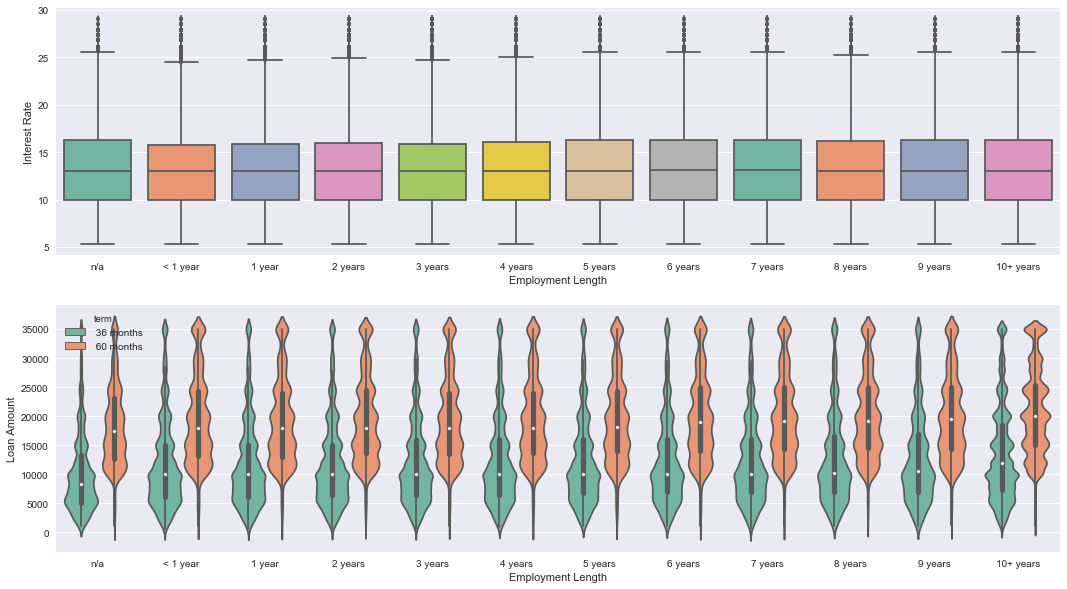

In [18]:
fig, ax = plt.subplots(2,1, figsize=(18,10))

empLengthOrder = ["n/a",'< 1 year','1 year','2 years','3 years','4 years', '5 years','6 years', '7 years', '8 years','9 years','10+ years']

tmpLoanDF = loanDF.select("emp_length", "int_rate", "loan_amnt", "term", "purpose").toPandas()

s0 = sns.boxplot(x="emp_length", y="int_rate", data=tmpLoanDF, palette="Set2", order=empLengthOrder ,ax=ax[0])
s0.set(xlabel='Employment Length',ylabel='Interest Rate')

s1 = sns.violinplot(x="emp_length", y="loan_amnt",data=tmpLoanDF, hue="term", palette="Set2", order=empLengthOrder ,ax=ax[1])
s1.set(xlabel='Employment Length',ylabel='Loan Amount')

plt.show()

fig.savefig("LoanAmountInt_OverEmploymentLength.pdf")

### Alalyzing loans by its purpose

- Number of loans by its purpose
- Loan amount with its distribution pattern by purpose; hues by its term
- Interest rate with its distribution pattern by purpose; hues by its term

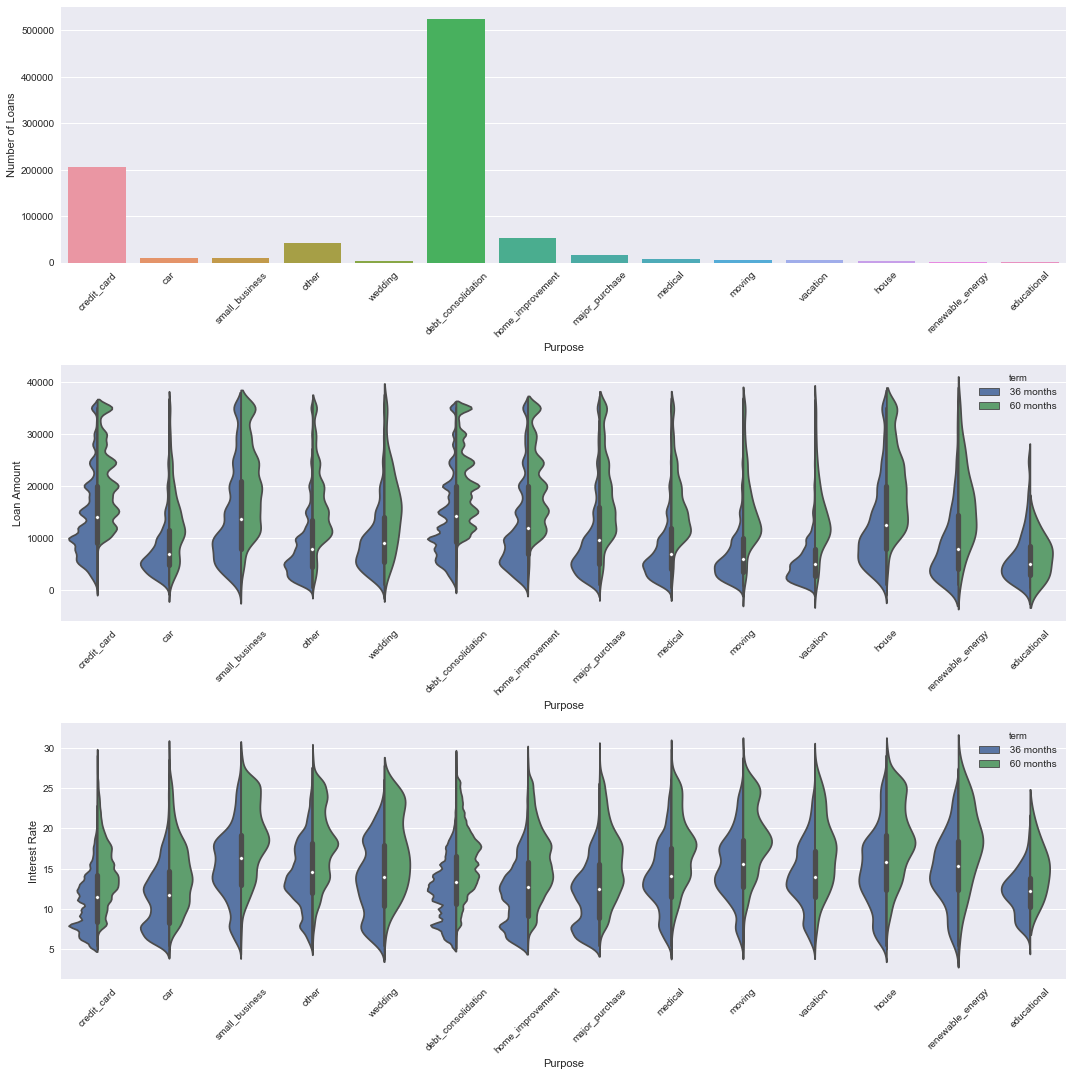

In [19]:
fig, ax=plt.subplots(3,1,figsize=(18,20))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

#Already collected this in the above section
#tmpLoanDF = loanDF.select("purpose", "int_rate", "loan_amnt",).toPandas()

s0 = sns.countplot(x="purpose",data=tmpLoanDF,ax=ax[0])
s0.set(xlabel='Purpose',ylabel='Number of Loans')
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

s1 = sns.violinplot(x="purpose",y="loan_amnt",data=tmpLoanDF, ax=ax[1], hue="term", split=True)
s1.set(xlabel='Purpose',ylabel='Loan Amount')
s1.set_xticklabels(s1.get_xticklabels(),rotation=45)

s2 = sns.violinplot(x="purpose",y="int_rate",data=tmpLoanDF, ax=ax[2], hue="term", split=True)
s2.set(xlabel='Purpose',ylabel='Interest Rate')
s2.set_xticklabels(s2.get_xticklabels(),rotation=45)


plt.show()

fig.savefig("LoanByPurpose.pdf")

### Creating interest range (Binning).
Creating interest range bins, to group by based on range <br> <br>

In [20]:
# Creating a int range columns 
loanDF = loanDF.withColumn("int_rate_range", when((col("int_rate") >= 5) & (col("int_rate") < 7), "5-7%")
                           .when((col("int_rate") >= 7) & (col("int_rate") < 9), "7-9%")
                          .when((col("int_rate") >= 9) & (col("int_rate") < 11), "9-11%")
                          .when((col("int_rate") >= 11) & (col("int_rate") < 13), "11-13%")
                          .when((col("int_rate") >= 13) & (col("int_rate") < 15), "13-15%")
                          .when((col("int_rate") >= 15) & (col("int_rate") < 20), "15-20%")
                          .when((col("int_rate") >= 20) & (col("int_rate") < 25), "20-25%")
                          .when((col("int_rate") >= 25) & (col("int_rate") < 30), "25-30%")
                          .otherwise(">30%"))

#loanDF.select("int_rate", "int_rate_range").show(50)

### Analyzing Default loans
Loan status which are in following status will be considered as defaulted - <br>
- Default, Late (31-120 days), 
- In Grace Period, Late (16-30 days), 
- Does not meet the credit policy. 
- Status:Charged Off <br>

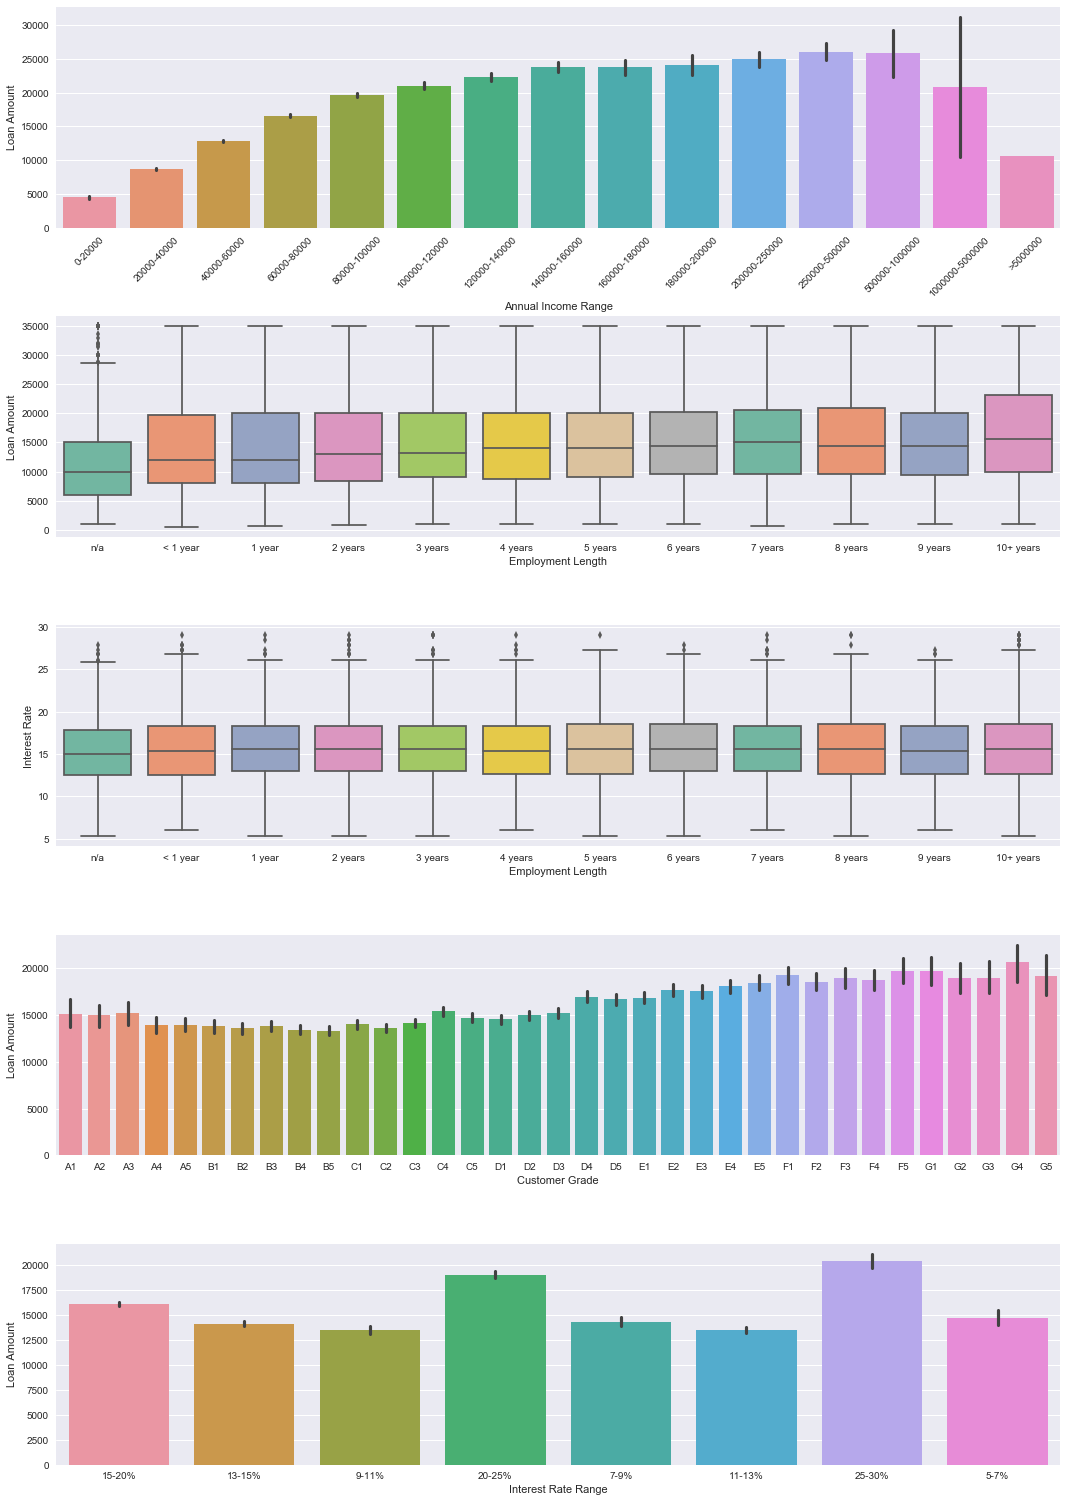

In [21]:
loanDF.registerTempTable("loanDFTable")

#mask = loanDF.loan_status.isin(["Default","Late (31-120 days)", "In Grace Period", "Late (16-30 days)", 
                                 #"Does not meet the credit policy. Status:Charged Off"])
#defaultLoanDF = loanDF.loc[mask]

defaultLoanDF = sqlContext.sql("select annual_inc_range, loan_amnt, emp_length, int_rate, sub_grade, int_rate_range  \
from loanDFTable \
where loan_status in ('Default','Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',\
'Does not meet the credit policy. Status:Charged Off')").toPandas()

#print(defaultLoanDF)

fig, ax = plt.subplots(5,1, figsize=(18,30))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

incRangeOrder = ["0-20000","20000-40000","40000-60000","60000-80000", "80000-100000", "100000-120000", "120000-140000", 
                "140000-160000", "160000-180000", "180000-200000", "200000-250000", "250000-500000", "500000-1000000",
                "1000000-5000000", ">5000000"]
s0 = sns.barplot(x="annual_inc_range", y="loan_amnt", data=defaultLoanDF, order=incRangeOrder, ax=ax[0])
s0.set(xlabel='Annual Income Range',ylabel='Loan Amount')
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

empLengthOrder = ["n/a",'< 1 year','1 year','2 years','3 years','4 years', '5 years','6 years', '7 years', '8 years','9 years','10+ years']

s1 = sns.boxplot(x="emp_length", y="loan_amnt", data=defaultLoanDF, palette="Set2", order=empLengthOrder ,ax=ax[1])
s1.set(xlabel='Employment Length',ylabel='Loan Amount')

s2 = sns.boxplot(x="emp_length", y="int_rate", data=defaultLoanDF, palette="Set2", order=empLengthOrder ,ax=ax[2])
s2.set(xlabel='Employment Length',ylabel='Interest Rate')

#s0 = sns.countplot(x="purpose",data=loanDF,ax=ax[0])
#s0.set(xlabel='Purpose',ylabel='Number of Loans')
#s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

#s1 = sns.violinplot(x="emp_length", y="loan_amnt",data=loanDF, hue="term", palette="Set2", order=empLengthOrder ,ax=ax[1])
#s1.set(xlabel='Employment Length',ylabel='Loan Amount')

subgradeOrder = ["A1", "A2", "A3", "A4", "A5", "B1", "B2", "B3", "B4", "B5", "C1", "C2", "C3", "C4", "C5", "D1", "D2", "D3", "D4", "D5",
                "E1", "E2", "E3", "E4", "E5", "F1", "F2", "F3", "F4", "F5", "G1", "G2", "G3", "G4", "G5"]
s3 = sns.barplot(x="sub_grade", y="loan_amnt", data=defaultLoanDF, order = subgradeOrder, ax=ax[3])
s3.set(xlabel='Customer Grade',ylabel='Loan Amount')

intRateRangeOrder = ["5-7%", "7-9%", "9-11%", "11-13%", "13-15%", "15-20%", "20-25%", "25-30%", ">30%"]
s4 = sns.barplot(x="int_rate_range", y="loan_amnt", data=defaultLoanDF, ax=ax[4])
s4.set(xlabel='Interest Rate Range',ylabel='Loan Amount')

plt.show()

fig.savefig("DefaultLoans.pdf")

In [22]:
## Preparing data for Learning model

loanDF.groupby("loan_status").count().show()

+--------------------+------+
|         loan_status| count|
+--------------------+------+
|          Fully Paid|207533|
|             Default|  1219|
|     In Grace Period|  6253|
|Does not meet the...|  1969|
|         Charged Off| 45215|
|  Late (31-120 days)| 11591|
|              Issued|  8460|
|             Current|601776|
|Does not meet the...|   751|
|   Late (16-30 days)|  2357|
+--------------------+------+



### Data Cleaning & Missing Data Imputation

In [23]:
# Cleaning up the data

######### 1. Removing all the features which has more than 50% of the data empty ##########
# Temporary setting these hard coded values. (Above section takes lot of time to run)
missingValueColList = ['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']
loanDFForModel = loanDF.drop(*missingValueColList)

######### 2. Removing unique ID columns ##########
# Dropping ID & date columns (Unique id's, Don't help much in data analysis/modelling)
loanDFForModel = loanDFForModel.drop("id", "member_id", "issue_d")
# Dropping the columns which were created for data analysis.
#loanDFForModel = loanDFForModel.drop("issue_d_dateType", "issue_year", "annual_inc_range")

######### 3. Removing Other insignificant columns ########## 
# application_type has only INDIVIDUAL, can be removed. 
# pymnt_plan & initial_list_status has only one category "n" & "f". Keeping state feature instead of zip_code.
# removing date fileds as well. policy_code has only one category "1"
loanDFForModel = loanDFForModel.drop("emp_title", "url", "title", "zip_code", "earliest_cr_line", "last_pymnt_d", 
                                     "next_pymnt_d", "last_credit_pull_d", "policy_code" )


######### 4. Missing data imputation for tot_cur_bal ########## 
# 90% of the missing data in "tot_cur_bal", "tot_coll_amt" column can be filled with 0 cause their loan status is "Fully Paid" OR "Charged Off"
loanDFForModel = loanDFForModel.withColumn("tot_cur_bal", when((col("tot_cur_bal").isNull() & 
                                                               col("loan_status").isin("Fully Paid", "Charged Off")), lit("0"))
                                          .otherwise(col("tot_cur_bal")))

loanDFForModel = loanDFForModel.withColumn("tot_coll_amt", when((col("tot_coll_amt").isNull() & 
                                                               col("loan_status").isin("Fully Paid", "Charged Off")), lit("0"))
                                          .otherwise(col("tot_coll_amt")))

# Inputing mean value for "total_rev_hi_lim"
mean = int(loanDFForModel.select(avg("total_rev_hi_lim")).take(1)[0][0])
loanDFForModel = loanDFForModel.withColumn("total_rev_hi_lim", when(col("total_rev_hi_lim").isNull(), lit(mean))
                                           .otherwise(col("total_rev_hi_lim")))

######### 5. Removing loan observations which still have missing data. (~ 0.8% records) ##########
#print("Total Loan Observations - ", loanDFForModel.count())
loanDFForModel = loanDFForModel.dropna(how="any") 
#print("Loan Observations after dropna- ",loanDFForModel.count())


######### 6. Adding the lable column to dataframe. 1- defalut and 0-paid/current ##########
loanDFForModel = loanDFForModel.withColumn("isDefault", when(col("loan_status").isin("Default","Charged Off", "Late (31-120 days)", "Late (16-30 days)", 
                                                                     "Does not meet the credit policy. Status:Charged Off"), 1)
                           .otherwise(0))
#loanDFForModel.groupby("isDefault").count().show()


######### 7. Changing the feature datatype from string to numeric ########## 
loanDFForModel = loanDFForModel.withColumn("loan_amnt",loanDFForModel["loan_amnt"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("funded_amnt",loanDFForModel["funded_amnt"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("funded_amnt_inv",loanDFForModel["funded_amnt_inv"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("int_rate",loanDFForModel["int_rate"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("installment",loanDFForModel["installment"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("annual_inc",loanDFForModel["annual_inc"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("dti",loanDFForModel["dti"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("delinq_2yrs",loanDFForModel["delinq_2yrs"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("inq_last_6mths",loanDFForModel["inq_last_6mths"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("open_acc",loanDFForModel["open_acc"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("pub_rec",loanDFForModel["pub_rec"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("revol_bal",loanDFForModel["revol_bal"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("revol_util",loanDFForModel["revol_util"].cast('float'))
loanDFForModel = loanDFForModel.withColumn("total_acc",loanDFForModel["total_acc"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("out_prncp",loanDFForModel["out_prncp"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("out_prncp_inv",loanDFForModel["out_prncp_inv"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("total_pymnt",loanDFForModel["total_pymnt"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("total_pymnt_inv",loanDFForModel["total_pymnt_inv"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("total_rec_prncp",loanDFForModel["total_rec_prncp"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("total_rec_int",loanDFForModel["total_rec_int"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("total_rec_late_fee",loanDFForModel["total_rec_late_fee"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("recoveries",loanDFForModel["recoveries"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("collection_recovery_fee",loanDFForModel["collection_recovery_fee"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("last_pymnt_amnt",loanDFForModel["last_pymnt_amnt"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("collections_12_mths_ex_med",loanDFForModel["collections_12_mths_ex_med"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("acc_now_delinq",loanDFForModel["acc_now_delinq"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("tot_coll_amt",loanDFForModel["tot_coll_amt"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("tot_cur_bal",loanDFForModel["tot_cur_bal"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("total_rev_hi_lim",loanDFForModel["total_rev_hi_lim"].cast('float'))
#loanDFForModel = loanDFForModel.withColumn("collection_recovery_fee",loanDFForModel["collection_recovery_fee"].cast('float'))


######### 8. Finally removing loan_status ########## 
#loan_status is used to create the class lable, removing it to avoid data leakage.
loanDFForModel = loanDFForModel.drop("loan_status")


######### 8. Removing the fileds which are related to the current loan ########## 
loanDFForModel = loanDFForModel.drop("out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", 
                                     "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee",
                                    "last_pymnt_amnt", "collections_12_mths_ex_med", "acc_now_delinq", "tot_coll_amt",
                                    "tot_cur_bal", "total_rev_hi_lim")


#print(type(loanDFForModel))
#loanDFForModel.printSchema()

# Term, grade, sub_grade, emp_length, home_ownership, verification_status, pymnt_plan, purpose, addr_state, 
# initial_list_status, application_type

### Binary Encoding for Categorical Feature - "term", "initial_list_status", "application_type", "pymnt_plan"
###### These features have only two categories

In [24]:
#indexer = StringIndexer(inputCol="term", outputCol="termIndex")
#loanDFForModel = indexer.fit(loanDFForModel).transform(loanDFForModel)

indexer = StringIndexer(inputCol="term", outputCol="termIndex", handleInvalid="keep")
loanDFForModel = indexer.fit(loanDFForModel).transform(loanDFForModel)

indexer = StringIndexer(inputCol="initial_list_status", outputCol="initial_list_statusIndex", handleInvalid="keep")
loanDFForModel = indexer.fit(loanDFForModel).transform(loanDFForModel)

indexer = StringIndexer(inputCol="application_type", outputCol="application_typeIndex", handleInvalid="keep")
loanDFForModel = indexer.fit(loanDFForModel).transform(loanDFForModel)

indexer = StringIndexer(inputCol="pymnt_plan", outputCol="pymnt_planIndex", handleInvalid="keep")
loanDFForModel = indexer.fit(loanDFForModel).transform(loanDFForModel)

#loanDFForModel.show()

### One-Hot Encoding for Categorical Feature - "grade"

In [25]:
#categories = loanDFForModel.select("grade").distinct().rdd.flatMap(lambda x: x).collect()
categories = loanDFForModel.select("grade").distinct().toPandas().grade.tolist()
#print(categories)
#print(type(categories))
exprs = [F.when(F.col("grade") == category, 1).otherwise(0).alias(category)
         for category in categories]

loanDFForModel = loanDFForModel.select("*", *exprs)

newCategories = []
for category in categories:
    loanDFForModel = loanDFForModel.withColumnRenamed(category, "grade_"+category)
    newCategories.append("grade_"+category)
print(newCategories)

['grade_F', 'grade_E', 'grade_B', 'grade_D', 'grade_C', 'grade_A', 'grade_G']


### One-Hot Encoding for Categorical Feature - "sub_grade"

In [26]:
#loanDF.registerTempTable("loanDFTable")
#categories = sqlContext.sql("select distinct(sub_grade) from loanDFTable").collect().toPandas()
categories = loanDFForModel.select("sub_grade").distinct().toPandas().sub_grade.tolist()
#print(categories)
#print(type(categories))
exprs = [F.when(F.col("sub_grade") == category, 1).otherwise(0).alias(category)
         for category in categories]

loanDFForModel = loanDFForModel.select("*", *exprs)

newCategories = []
for category in categories:
    loanDFForModel = loanDFForModel.withColumnRenamed(category, "sub_grade_"+category)
    newCategories.append("sub_grade_"+category)
print(newCategories)

['sub_grade_D5', 'sub_grade_F2', 'sub_grade_B4', 'sub_grade_A2', 'sub_grade_E4', 'sub_grade_B2', 'sub_grade_C3', 'sub_grade_D1', 'sub_grade_C4', 'sub_grade_F1', 'sub_grade_D3', 'sub_grade_F5', 'sub_grade_G2', 'sub_grade_B1', 'sub_grade_B3', 'sub_grade_E5', 'sub_grade_C5', 'sub_grade_G3', 'sub_grade_A4', 'sub_grade_F4', 'sub_grade_B5', 'sub_grade_E3', 'sub_grade_G4', 'sub_grade_D2', 'sub_grade_C1', 'sub_grade_F3', 'sub_grade_E1', 'sub_grade_A5', 'sub_grade_C2', 'sub_grade_D4', 'sub_grade_E2', 'sub_grade_A3', 'sub_grade_G5', 'sub_grade_G1', 'sub_grade_A1']


### One-Hot Encoding for Categorical Feature - "home_ownership"

In [27]:
#categories = loanDFForModel.select("home_ownership").distinct().rdd.flatMap(lambda x: x).collect()
categories = loanDFForModel.select("home_ownership").distinct().toPandas().home_ownership.tolist()
#print(categories)
exprs = [F.when(F.col("home_ownership") == category, 1).otherwise(0).alias(category)
         for category in categories]

loanDFForModel = loanDFForModel.select("*", *exprs)

newCategories = []
for category in categories:
    loanDFForModel = loanDFForModel.withColumnRenamed(category, "home_ownership_"+category)
    newCategories.append("home_ownership_"+category)
print(newCategories)

['home_ownership_OWN', 'home_ownership_RENT', 'home_ownership_MORTGAGE', 'home_ownership_ANY', 'home_ownership_OTHER', 'home_ownership_NONE']


### One-Hot Encoding for Categorical Feature - "verification_status"

In [28]:
#categories = loanDFForModel.select("verification_status").distinct().rdd.flatMap(lambda x: x).collect()
categories = loanDFForModel.select("verification_status").distinct().toPandas().verification_status.tolist()
#print(categories)
exprs = [F.when(F.col("verification_status") == category, 1).otherwise(0).alias(category)
         for category in categories]

loanDFForModel = loanDFForModel.select("*", *exprs)

newCategories = []
for category in categories:
    loanDFForModel = loanDFForModel.withColumnRenamed(category, "verification_status_"+category)
    newCategories.append("verification_status_"+category)
print(newCategories)

['verification_status_Verified', 'verification_status_Source Verified', 'verification_status_Not Verified']


### One-Hot Encoding for Categorical Feature - "purpose"

In [29]:
#categories = loanDFForModel.select("purpose").distinct().rdd.flatMap(lambda x: x).collect()
categories = loanDFForModel.select("purpose").distinct().toPandas().purpose.tolist()
#print(categories)
exprs = [F.when(F.col("purpose") == category, 1).otherwise(0).alias(category)
         for category in categories]

loanDFForModel = loanDFForModel.select("*", *exprs)

newCategories = []
for category in categories:
    loanDFForModel = loanDFForModel.withColumnRenamed(category, "purpose_"+category)
    newCategories.append("purpose_"+category)
print(newCategories)

['purpose_wedding', 'purpose_educational', 'purpose_other', 'purpose_small_business', 'purpose_debt_consolidation', 'purpose_credit_card', 'purpose_moving', 'purpose_vacation', 'purpose_renewable_energy', 'purpose_house', 'purpose_car', 'purpose_major_purchase', 'purpose_medical', 'purpose_home_improvement']


### One-Hot Encoding for Categorical Feature - "addr_state"

In [30]:
#categories = loanDFForModel.select("addr_state").distinct().rdd.flatMap(lambda x: x).collect()
categories = loanDFForModel.select("addr_state").distinct().toPandas().addr_state.tolist()
#print(categories)
exprs = [F.when(F.col("addr_state") == category, 1).otherwise(0).alias(category)
         for category in categories]

loanDFForModel = loanDFForModel.select("*", *exprs)

newCategories = []
for category in categories:
    loanDFForModel = loanDFForModel.withColumnRenamed(category, "addr_state_"+category)
    newCategories.append("addr_state_"+category)
print(newCategories)

['addr_state_AZ', 'addr_state_SC', 'addr_state_LA', 'addr_state_MN', 'addr_state_NJ', 'addr_state_DC', 'addr_state_OR', 'addr_state_VA', 'addr_state_RI', 'addr_state_KY', 'addr_state_WY', 'addr_state_NH', 'addr_state_MI', 'addr_state_NV', 'addr_state_WI', 'addr_state_ID', 'addr_state_CA', 'addr_state_CT', 'addr_state_NE', 'addr_state_MT', 'addr_state_NC', 'addr_state_VT', 'addr_state_MD', 'addr_state_DE', 'addr_state_MO', 'addr_state_IL', 'addr_state_ME', 'addr_state_WA', 'addr_state_ND', 'addr_state_MS', 'addr_state_AL', 'addr_state_IN', 'addr_state_OH', 'addr_state_TN', 'addr_state_NM', 'addr_state_IA', 'addr_state_PA', 'addr_state_SD', 'addr_state_NY', 'addr_state_TX', 'addr_state_WV', 'addr_state_GA', 'addr_state_MA', 'addr_state_KS', 'addr_state_FL', 'addr_state_CO', 'addr_state_AK', 'addr_state_AR', 'addr_state_OK', 'addr_state_UT', 'addr_state_HI']


In [31]:
loanDFForModel.printSchema()

#loanDFForModel = loanDFForModel.withColumnRenamed("D5", "sub_grade_D5")

#loanDFForModel.printSchema()

root
 |-- loan_amnt: float (nullable = true)
 |-- funded_amnt: float (nullable = true)
 |-- funded_amnt_inv: float (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: float (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: float (nullable = true)
 |-- inq_last_6mths: float (nullable = true)
 |-- open_acc: float (nullable = true)
 |-- pub_rec: float (nullable = true)
 |-- revol_bal: float (nullable = true)
 |-- revol_util: float (nullable = true)
 |-- total_acc: float (nullable = true)
 |-- initial_list_status: string (nullable = true)

### Converting Categorical feature "emp_lenght" to continous feature

In [32]:
loanDFForModel = loanDFForModel.withColumn("emp_lengthIndex", when(col("emp_length") == "< 1 year", 0)
                                           .when(col("emp_length") == "1 year", 1)
                                           .when(col("emp_length") == "2 years", 2)
                                           .when(col("emp_length") == "3 years", 3)
                                           .when(col("emp_length") == "4 years", 4)
                                           .when(col("emp_length") == "5 years", 5)
                                           .when(col("emp_length") == "6 years", 6)
                                           .when(col("emp_length") == "7 years", 7)
                                           .when(col("emp_length") == "8 years", 8)
                                           .when(col("emp_length") == "9 years", 9)
                                           .when(col("emp_length") == "10+ years", 10)
                                           .otherwise(0))

### Dropping categorical features after One-Hot encoding

In [33]:
# Remove the original categorical columns after encoding.
loanDFForModel = loanDFForModel.drop("term", "initial_list_status", "application_type", "pymnt_plan", "grade", "sub_grade", 
                                     "home_ownership", "verification_status", "purpose", "addr_state", "emp_length")

loanDFForModel = loanDFForModel.withColumn("ClassLable", col("isDefault"))
loanDFForModel = loanDFForModel.drop("isDefault")

loanDFForModel.printSchema()

root
 |-- loan_amnt: float (nullable = true)
 |-- funded_amnt: float (nullable = true)
 |-- funded_amnt_inv: float (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: float (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: float (nullable = true)
 |-- inq_last_6mths: float (nullable = true)
 |-- open_acc: float (nullable = true)
 |-- pub_rec: float (nullable = true)
 |-- revol_bal: float (nullable = true)
 |-- revol_util: float (nullable = true)
 |-- total_acc: float (nullable = true)
 |-- issue_d_dateType: date (nullable = true)
 |-- issue_year: string (nullable = true)
 |-- annual_inc_range: string (nullable = false)
 |-- int_rate_range: string (nullable = false)
 |-- termIndex: double (nullable = false)
 |-- initial_list_statusIndex: double (nullable = false)
 |-- application_typeIndex: double (nullable = false)
 |-- pymnt_planIndex: double (nullable = false)
 |-- grade_F: integer (nullable = false)


In [34]:
loanDFForModel.groupby("ClassLable").count().show()

+----------+------+
|ClassLable| count|
+----------+------+
|         1| 60153|
|         0|819919|
+----------+------+



### Adding a Weight Column to handle class imbalancing. 

In [35]:
# Adding a weight columns to the dataset to handel class imbalance
# Hardcoding it to save some execution time - (60153/819919) - (#Default Loans / #Total Loans)
balancingRatio  = 0.0735

loanDFForModel = loanDFForModel.withColumn("weightColumn", when(col("ClassLable") == 0, balancingRatio)
                                           .otherwise((1-balancingRatio)))

#loanDFForModel.groupby("weightColumn").count().show()

In [36]:
loanDFForModel = loanDFForModel.drop("issue_d_dateType", "issue_year", "annual_inc_range", "int_rate_range")

In [37]:
colList = loanDFForModel.columns
print(colList)
print(len(colList))
colList.remove("ClassLable")
print(colList)
print(len(colList))

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'termIndex', 'initial_list_statusIndex', 'application_typeIndex', 'pymnt_planIndex', 'grade_F', 'grade_E', 'grade_B', 'grade_D', 'grade_C', 'grade_A', 'grade_G', 'sub_grade_D5', 'sub_grade_F2', 'sub_grade_B4', 'sub_grade_A2', 'sub_grade_E4', 'sub_grade_B2', 'sub_grade_C3', 'sub_grade_D1', 'sub_grade_C4', 'sub_grade_F1', 'sub_grade_D3', 'sub_grade_F5', 'sub_grade_G2', 'sub_grade_B1', 'sub_grade_B3', 'sub_grade_E5', 'sub_grade_C5', 'sub_grade_G3', 'sub_grade_A4', 'sub_grade_F4', 'sub_grade_B5', 'sub_grade_E3', 'sub_grade_G4', 'sub_grade_D2', 'sub_grade_C1', 'sub_grade_F3', 'sub_grade_E1', 'sub_grade_A5', 'sub_grade_C2', 'sub_grade_D4', 'sub_grade_E2', 'sub_grade_A3', 'sub_grade_G5', 'sub_grade_G1', 'sub_grade_A1', 'home_ownership_OWN', 'home_ownership_RENT', 'home_ownership_MORTGAGE', 'home_ownershi

### Vectorizing feature columns 

In [38]:
#assembler = VectorAssembler(inputCols=[ *colList ], outputCol="features")

#transformed = assembler.transform(loanDFForModel)

#trainLablePoint = transformed.select(col("isDefault").alias("label"), col("features")).rdd.map(lambda row: LabeledPoint(row.label, row.features))

# set the input and output column names
assembler = VectorAssembler(inputCols=[ *colList ], outputCol="features")

loanDFTransformed = assembler.transform( loanDFForModel)

loanDFTransformed.show(5)

+---------+-----------+---------------+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+---------+------------------------+---------------------+---------------+-------+-------+-------+-------+-------+-------+-------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------------+-------------------+-----------------------+------------------+--------------------+-------------------+----------------------------+-----------------------------------+--------------------------------+---------------+-------------------+-------

### Creating LabelPoint, adding the class lable in transformed data

In [39]:
#abelIndexer = new StringIndexer().setInputCol("creditability").setOutputCol("label")
labelIndexer = StringIndexer(inputCol="ClassLable", outputCol="label", handleInvalid="keep")
#val df3 = labelIndexer.fit(df2).transform(df2)
loanDFTransformed_2 = labelIndexer.fit(loanDFTransformed).transform(loanDFTransformed)

loanDFTransformed_2.show(5)

#indexer = StringIndexer(inputCol="term", outputCol="termIndex", handleInvalid="keep")
#loanDFTransformed = indexer.fit(loanDFForModel).transform(loanDFForModel)

+---------+-----------+---------------+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+---------+------------------------+---------------------+---------------+-------+-------+-------+-------+-------+-------+-------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------------+-------------------+-----------------------+------------------+--------------------+-------------------+----------------------------+-----------------------------------+--------------------------------+---------------+-------------------+-------

### PCA Test

In [40]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
pca_Model = pca.fit(loanDFTransformed_2)

result = pca_Model.transform(loanDFTransformed_2)
result.show(truncate=False)

loanDFTransformed_2 = result

+---------+-----------+---------------+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+---------+------------------------+---------------------+---------------+-------+-------+-------+-------+-------+-------+-------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------------+-------------------+-----------------------+------------------+--------------------+-------------------+----------------------------+-----------------------------------+--------------------------------+---------------+-------------------+-------

### Train/Test split based on the hardcoded seed value (70 : 30)

In [41]:
# Creating Training and Test set (70% , 30%)
(trainingSetDF, testSetDF) = loanDFTransformed_2.randomSplit([0.7, 0.3], 1395)

trainingSetDF.cache()
testSetDF.cache()

#print(transformedData.count())
#print(trainingSetDF.count())
#print(testSetDF.count())



DataFrame[loan_amnt: float, funded_amnt: float, funded_amnt_inv: float, int_rate: float, installment: float, annual_inc: float, dti: float, delinq_2yrs: float, inq_last_6mths: float, open_acc: float, pub_rec: float, revol_bal: float, revol_util: float, total_acc: float, termIndex: double, initial_list_statusIndex: double, application_typeIndex: double, pymnt_planIndex: double, grade_F: int, grade_E: int, grade_B: int, grade_D: int, grade_C: int, grade_A: int, grade_G: int, sub_grade_D5: int, sub_grade_F2: int, sub_grade_B4: int, sub_grade_A2: int, sub_grade_E4: int, sub_grade_B2: int, sub_grade_C3: int, sub_grade_D1: int, sub_grade_C4: int, sub_grade_F1: int, sub_grade_D3: int, sub_grade_F5: int, sub_grade_G2: int, sub_grade_B1: int, sub_grade_B3: int, sub_grade_E5: int, sub_grade_C5: int, sub_grade_G3: int, sub_grade_A4: int, sub_grade_F4: int, sub_grade_B5: int, sub_grade_E3: int, sub_grade_G4: int, sub_grade_D2: int, sub_grade_C1: int, sub_grade_F3: int, sub_grade_E1: int, sub_grade

### Method to compute the model evaluation matrix

In [48]:
def getEvaluationMatrix(predicDF):
    lablePrediction = predicDF.select( "label", "prediction")
    lablePrediction.cache()
    totalCount = lablePrediction.count()
    correctCount = lablePrediction.filter(col("label") == col("prediction")).count()
    wrongCount = lablePrediction.filter(~(col("label") == col("prediction"))).count()
    trueP = lablePrediction.filter(col("label") == 0.0).filter(col("label") == col("prediction")).count()
    trueN = lablePrediction.filter(col("label") == 1.0).filter(col("label") == col("prediction")).count()
    falseN = lablePrediction.filter(col("label") == 1.0).filter(~(col("label") == col("prediction"))).count()
    falseP = lablePrediction.filter(col("label") == 0.0).filter(~(col("label") == col("prediction"))).count()

    ratioWrong = float(wrongCount) / float(totalCount) 
    ratioCorrect = float(correctCount)/ float(totalCount)

    print("totalCount   - ", totalCount)
    print("correctCount - ", correctCount)
    print("wrongCount   - ", wrongCount)
    print("trueP        - ", trueP)
    print("trueN        - ", trueN)
    print("falseN       - ", falseN)
    print("falseP       - ", falseP)
    print("ratioWrong   - ", ratioWrong)
    print("ratioCorrect - ", ratioCorrect)
    
    precision = ((float(trueP) / (float(trueP) + float(falseP))) * 100 )
    recall = ((float(trueP) / (float(trueP) + float(falseN))) * 100 )
    print("Accuracy     - ", (trueP + trueN) / totalCount)
    print("Precision    - ", precision)
    print("Recall       - ", recall)
    print("F-1 Score    - ", ((2* ( (precision*recall) / (precision + recall))) ))
    print("Sensitivity  - ", ((float(trueP) / (float(trueP) + float(falseN))) * 100 ))
    print("Specificity  - ", ((float(trueN) / (float(trueN) + float(falseP))) * 100 ))
    
    createROC(predictions)
    

### Method to compute the ROC Curve

In [43]:
def createROC(predictions):
    results = predictions.select(['probability', 'label'])
 
    ## prepare score-label set
    results_collect = results.collect()
    results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
    scoreAndLabels = spark.sparkContext.parallelize(results_list)
 
    bcMetrics = BinaryClassificationMetrics(scoreAndLabels)
    print("ROC score is - ", bcMetrics.areaUnderROC)
        
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
 
    y_test = [i[1] for i in results_list]
    y_score = [i[0] for i in results_list]
 
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
 
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### Logistic Regression Classifier

**** Running Logistic Regression Classifier with best parameter found using ML pipeline **** 
totalCount   -  264025
correctCount -  251938
wrongCount   -  12087
trueP        -  236174
trueN        -  15764
falseN       -  2375
falseP       -  9712
ratioWrong   -  0.045779755704952185
ratioCorrect -  0.9542202442950478
Accuracy     -  0.9542202442950478
Precision    -  96.05020212618855
Recall       -  99.00439741939812
F-1 Score    -  97.50492842176969
Sensitivity  -  99.00439741939812
Specificity  -  61.87784581566965
ROC score is -  0.9789662436081351


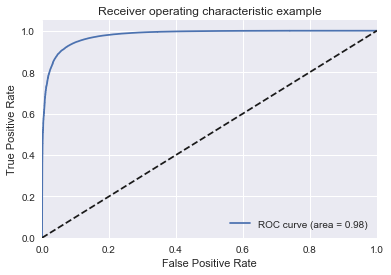

In [49]:
print("**** Running Logistic Regression Classifier with best parameter found using ML pipeline **** ")

# Create initial LogisticRegression model
lr_classifier = LogisticRegression(labelCol="label", featuresCol="features", maxIter=3, weightCol="weightColumn")
#lr_classifier = LogisticRegression(labelCol="label", featuresCol="pcaFeatures", maxIter=10, weightCol="weightColumn")

# Train model with Training Data
lrModel = lr_classifier.fit(trainingSetDF)

# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testSetDF)

# Evaluate model
evaluator = BinaryClassificationEvaluator( labelCol="label")
lr_accuracy = evaluator.evaluate(predictions)

#print(lr_accuracy)

getEvaluationMatrix(predictions)

## DO NOT RUN THIS, IT WILL TAKE 30-45 MINS TO RUN
### Logistic Regression Classifier with ML Pipeline to find the best hyper parameters Using Cross Validation

In [99]:
#paramGrid = ParamGridBuilder().addGrid(lr_classifier.regParam, [0.01, 0.1, 1.0]).addGrid(lr_classifier.elasticNetParam, [0.0, 0.5, 1.0]).addGrid(lr_classifier.maxIter, [1, 3, 10]).build()

#pipeline = Pipeline(stages=[ lr_classifier ])

#evaluator = BinaryClassificationEvaluator( labelCol = "label" )

#crossval_lr = CrossValidator( estimator = pipeline, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 10)

# Run cross-validation, and choose the best set of parameters.
#cvModel_lr = crossval_lr.fit( trainingSetDF )

#cvLR_predictions = cvModel_lr.transform(testSetDF)
#cvLR_accuracy = evaluator.evaluate(cvLR_predictions)  

#bestModel = cvModel_lr.bestModel
#print(cvModel_lr.avgMetrics)
#print(list(zip(cvModel_lr.avgMetrics, paramGrid)))

#print(bestModel.stages[0]._java_obj.getRegParam())
#print(bestModel.stages[0]._java_obj.getElasticNetParam())
#print(bestModel.stages[0]._java_obj.getMaxIter())

#print(cvLR_accuracy) 

#getEvaluationMatrix(cvLR_predictions)

### NaiveBayes Classifier

**** Running NaiveBayes Classifier with best parameter found using ML pipeline **** 
totalCount   -  264025
correctCount -  133578
wrongCount   -  130447
trueP        -  122845
trueN        -  10733
falseN       -  7406
falseP       -  123041
ratioWrong   -  0.4940706372502604
ratioCorrect -  0.5059293627497397
Accuracy     -  0.5059293627497397
Precision    -  49.96014413183345
Recall       -  94.31405517040177
F-1 Score    -  65.31928526042374
Sensitivity  -  94.31405517040177
Specificity  -  8.02323321422698
ROC score is -  0.5515395015887257


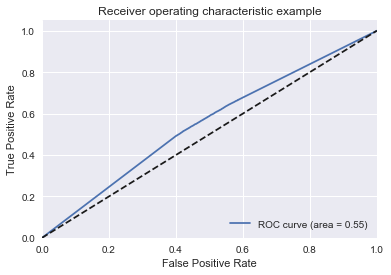

In [50]:
print("**** Running NaiveBayes Classifier with best parameter found using ML pipeline **** ")
# Create initial NaiveBayes model
nb_classifier = NaiveBayes(labelCol="label", featuresCol="features", smoothing=50, weightCol="weightColumn")
#nb_classifier = NaiveBayes(labelCol="label", featuresCol="pcaFeatures", smoothing=50, weightCol="weightColumn" )

# Train model with Training Data
nbModel = nb_classifier.fit(trainingSetDF)

# Make predictions on test data using the transform() method.
# NaiveBayes.transform() will only use the 'features' column.
predictions = nbModel.transform(testSetDF)

# Evaluate model
evaluator = MulticlassClassificationEvaluator( labelCol="label", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(predictions)

#print(nb_accuracy)

getEvaluationMatrix(predictions)

## DO NOT RUN THIS, IT WILL TAKE 30-45 MINS TO RUN
### NaiveBayes Classifier with ML Pipeline to find the best hyper parameters Using Cross Validation

In [101]:
#paramGrid = ParamGridBuilder().addGrid(nb_classifier.smoothing, [1.0, 2.0, 3.0])).build()

#pipeline = Pipeline(stages=[ nb_classifier ])

#evaluator = MulticlassClassificationEvaluator( labelCol="label", predictionCol="prediction", metricName="accuracy")

#crossval_nb = CrossValidator( estimator = pipeline, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 10)

# Run cross-validation, and choose the best set of parameters.
#cvModel_nb = crossval_nb.fit( trainingSetDF )

#cvNB_predictions = cvModel_nb.transform(testSetDF)
#cvNB_accuracy = evaluator.evaluate(cvNB_predictions)  

#bestModel = cvModel_nb.bestModel
#print(cvModel_nb.avgMetrics)
#print(list(zip(cvModel_nb.avgMetrics, paramGrid)))

#print(bestModel.stages[0]._java_obj.getSmoothing())

#print(cvNB_accuracy) 

#getEvaluationMatrix(cvNB_predictions)

### Random Forest Classifier

**** Running Random Forest Classifier with best parameter found using ML pipeline **** 
totalCount   -  264025
correctCount -  263981
wrongCount   -  44
trueP        -  245886
trueN        -  18095
falseN       -  44
falseP       -  0
ratioWrong   -  0.00016665088533282833
ratioCorrect -  0.9998333491146671
Accuracy     -  0.9998333491146671
Precision    -  100.0
Recall       -  99.98210873012646
F-1 Score    -  99.99105356474779
Sensitivity  -  99.98210873012646
Specificity  -  100.0
ROC score is -  1.0


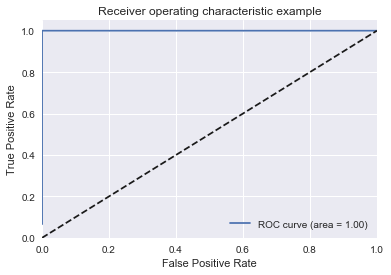

In [51]:
# Create initial Random Forest Classifier model
print("**** Running Random Forest Classifier with best parameter found using ML pipeline **** ")
rf_classifier = RandomForestClassifier( impurity="gini", maxDepth=12, numTrees=10, featureSubsetStrategy="auto", seed=1395)

# Train model with Training Data
rf_model = rf_classifier.fit(trainingSetDF)

# Print the Forest tree rules. 
#rf_model.toDebugString

# Make predictions on test data using the transform() method.
# RandomForest.transform() will only use the 'features' column.
predictions = rf_model.transform(testSetDF)

#predictions.show(5)

evaluator = BinaryClassificationEvaluator( labelCol = "label" )
rf_accuracy = evaluator.evaluate(predictions)

#print("accuracy - ", rf_accuracy)

getEvaluationMatrix(predictions)

## DO NOT RUN THIS, IT WILL TAKE 30-45 MINS TO RUN
### Random Forest Classifier with ML Pipeline to find the best hyper parameters Using Cross Validation

In [97]:
#paramGrid = ParamGridBuilder().addGrid(rf_classifier.maxBins, [25, 28, 31, 34]).addGrid(rf_classifier.maxDepth, [4, 6, 8, 12]).addGrid(rf_classifier.impurity, ["entropy", "gini"]).build()

#pipeline = Pipeline(stages=[ rf_classifier ])

#evaluator = BinaryClassificationEvaluator( labelCol = "label" )

#crossval = CrossValidator( estimator = pipeline, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 10)

# Run cross-validation, and choose the best set of parameters.
#cvModel = crossval.fit( trainingSetDF )

#cv_predictions = cvModel.transform(testSetDF)
#cv_accuracy = evaluator.evaluate(cv_predictions)  

#bestModel = cvModel.bestModel
#print(cvModel.avgMetrics)
#print(list(zip(cvModel.avgMetrics, paramGrid)))

#print(bestModel.stages[0]._java_obj.getMaxBins())
#print(bestModel.stages[0]._java_obj.getMaxDepth())
#print(bestModel.stages[0]._java_obj.getImpurity())

#print(cv_accuracy) 

#getEvaluationMatrix(cv_predictions)

### Gradient Boosting Classifier

**** Running Gradient Boosting Classifier with best parameter found using ML pipeline **** 
totalCount   -  264025
correctCount -  264025
wrongCount   -  0
trueP        -  245886
trueN        -  18139
falseN       -  0
falseP       -  0
ratioWrong   -  0.0
ratioCorrect -  1.0
Accuracy     -  1.0
Precision    -  100.0
Recall       -  100.0
F-1 Score    -  100.0
Sensitivity  -  100.0
Specificity  -  100.0
ROC score is -  1.0


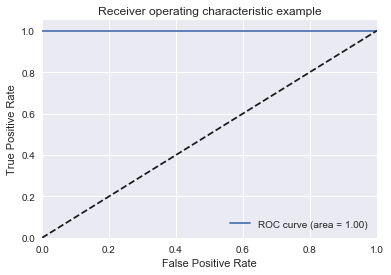

In [54]:
print("**** Running Gradient Boosting Classifier with best parameter found using ML pipeline **** ")

# Create initial Gradient Boosting Classifier model
gb_classifier = GBTClassifier(labelCol="label", featuresCol="features", maxDepth=5, maxBins=5, lossType="logistic", maxIter=10, stepSize=.00000001)
#gb_classifier = GBTClassifier(labelCol="label", featuresCol="pcaFeatures", maxDepth=1, maxBins=5, lossType="logistic", maxIter=1, stepSize=.00000001)

# Train model with Training Data
gbModel = gb_classifier.fit(trainingSetDF)

# Make predictions on test data using the transform() method.
# NaiveBayes.transform() will only use the 'features' column.
predictions = gbModel.transform(testSetDF)

# Evaluate model
evaluator = MulticlassClassificationEvaluator( labelCol="label", predictionCol="prediction", metricName="accuracy")
gb_accuracy = evaluator.evaluate(predictions)

#print(gb_accuracy)

getEvaluationMatrix(predictions)

## DO NOT RUN THIS, IT WILL TAKE 30-45 MIN TO RUN
### Gradient Boosting Classifier with ML Pipeline to find the best hyper parameters Using Cross Validation

In [105]:
#paramGrid = ParamGridBuilder().addGrid(gb_classifier.maxDepth, [3, 5, 10]).addGrid(gb_classifier.maxIter, [5, 10, 15]).addGrid(gb_classifier.stepSize, [0.01, 0.1, 1.0]).build()

#pipeline = Pipeline(stages=[ gb_classifier ])

#evaluator = MulticlassClassificationEvaluator( labelCol="label", predictionCol="prediction", metricName="accuracy")

#crossval_gb = CrossValidator( estimator = pipeline, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 10)

# Run cross-validation, and choose the best set of parameters.
#cvModel_gb = crossval_gb.fit( trainingSetDF )

#cvGB_predictions = cvModel_gb.transform(testSetDF)
#cvGB_accuracy = evaluator.evaluate(cvGB_predictions)  

#bestModel = cvModel_gb.bestModel
#print(cvModel_gb.avgMetrics)
#print(list(zip(cvModel_gb.avgMetrics, paramGrid)))

#print(bestModel.stages[0]._java_obj.getMaxDepth())
#print(bestModel.stages[0]._java_obj.getMaxIter())
#print(bestModel.stages[0]._java_obj.getStepSize())

#print(cvGB_accuracy) 

#getEvaluationMatrix(cvGB_predictions)

## THIS NEEDS TO BE FIXED, ITS THROWING SOME EXCEPTION
### SVM Classifier

In [102]:
# Create initial SVM model
print("**** Running SVM Classifier with best parameter found using ML pipeline **** ")
#svm_classifier = LinearSVC(labelCol="label", featuresCol="features", maxIter=50, regParam=0.1)
#svm_classifier = LinearSVC(labelCol="label", featuresCol="pcaFeatures", maxIter=50, regParam=0.1)

# Train model with Training Data
#svmModel = svm_classifier.fit(trainingSetDF)

# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
#predictions = svmModel.transform(testSetDF)

# Evaluate model
#evaluator = BinaryClassificationEvaluator( labelCol="label")
#svm_accuracy = evaluator.evaluate(predictions)

#print(svm_accuracy)

#getEvaluationMatrix(predictions)

**** Running SVM Classifier with best parameter found using ML pipeline **** 


## DO NOT RUN THIS, IT WILL TAKE 30-45 MINS TO RUN
### SVM Classifier with ML Pipeline to find the best hyper parameters Using Cross Validation

In [103]:
#paramGrid = ParamGridBuilder().addGrid(svm_classifier.regParam, [0.01, 0.1, 1.0]).addGrid(svm_classifier.maxIter, [50, 75, 100])).build()

#pipeline = Pipeline(stages=[ svm_classifier ])

#evaluator = BinaryClassificationEvaluator( labelCol = "label" )

#crossval_svm = CrossValidator( estimator = pipeline, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 10)

# Run cross-validation, and choose the best set of parameters.
#cvModel_svm = crossval_svm.fit( trainingSetDF )

#cvSVM_predictions = cvModel_svm.transform(testSetDF)
#cvSVM_accuracy = evaluator.evaluate(cvSVM_predictions) 

#bestModel = cvModel_svm.bestModel
#print(cvModel_svm.avgMetrics)
#print(list(zip(cvModel_svm.avgMetrics, paramGrid)))

#print(bestModel.stages[0]._java_obj.getRegParam())
#print(bestModel.stages[0]._java_obj.getMaxIter())
#print(bestModel.stages[0]._java_obj.getSmoothing())

#print(cvSVM_accuracy) 

#getEvaluationMatrix(cvSVM_predictions)